In [1]:
import sys, os
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.config import PROCESSED_RETURNS_PARQUET


In [3]:
rets = pd.read_parquet(PROCESSED_RETURNS_PARQUET).dropna(how="any")
assets = rets.columns.tolist()

# Baseline weights (Equal + MVO)
w_base = pd.read_csv("data/processed/baseline_weights.csv", index_col=0)
w_equal = w_base.loc[assets, "Equal Weight"].values
w_mvo   = w_base.loc[assets, "Mean-Variance"].values

# Risk Parity weights
rp_df = pd.read_csv("data/processed/risk_parity_weights_and_risk.csv", index_col=0)
w_rp = rp_df.loc[assets, "weight"].values

cov_full = rets.cov().values


In [4]:
def portfolio_vol(w, cov):
    return np.sqrt(w.T @ cov @ w)

def mrc(w, cov):
    # Marginal risk contribution to portfolio vol
    pv = portfolio_vol(w, cov)
    return (cov @ w) / pv

def crc(w, cov):
    # Component risk contribution (adds up to portfolio vol)
    return w * mrc(w, cov)

def risk_table(w, cov, assets, name):
    pv = portfolio_vol(w, cov)
    c = crc(w, cov)
    out = pd.DataFrame({
        "portfolio": name,
        "weight": w,
        "mrc": mrc(w, cov),
        "crc": c,
        "risk_pct": c / c.sum(),
    }, index=assets)
    out["port_vol_daily"] = pv
    return out


In [5]:
tab_equal = risk_table(w_equal, cov_full, assets, "Equal Weight")
tab_mvo   = risk_table(w_mvo,   cov_full, assets, "Mean-Variance")
tab_rp    = risk_table(w_rp,    cov_full, assets, "Risk Parity")

static = pd.concat([tab_equal, tab_mvo, tab_rp]).reset_index().rename(columns={"index":"ticker"})
static.head()


,ticker,portfolio,weight,mrc,crc,risk_pct,port_vol_daily
0,AAPL,Equal Weight,0.022222,0.012753,0.000283,0.031849,0.008898
1,AGG,Equal Weight,0.022222,0.000464,0.000010,0.001160,0.008898
2,AMZN,Equal Weight,0.022222,0.012884,0.000286,0.032177,0.008898
3,BAC,Equal Weight,0.022222,0.013658,0.000304,0.034108,0.008898
4,BRK-B,Equal Weight,0.022222,0.009277,0.000206,0.023169,0.008898


In [6]:
def top_risk_contributors(tab, top_n=10):
    return tab.sort_values("risk_pct", ascending=False).head(top_n)[["weight","risk_pct","crc","mrc"]]

top_equal = top_risk_contributors(tab_equal, 10)
top_mvo   = top_risk_contributors(tab_mvo, 10)
top_rp    = top_risk_contributors(tab_rp, 10)

top_equal, top_mvo, top_rp


(        weight  risk_pct       crc       mrc
 TSLA  0.022222  0.047528  0.000423  0.019031
 NVDA  0.022222  0.046181  0.000411  0.018491
 META  0.022222  0.035479  0.000316  0.014206
 BAC   0.022222  0.034108  0.000304  0.013658
 GS    0.022222  0.033821  0.000301  0.013542
 XLK   0.022222  0.032213  0.000287  0.012899
 AMZN  0.022222  0.032177  0.000286  0.012884
 AAPL  0.022222  0.031849  0.000283  0.012753
 MSFT  0.022222  0.031132  0.000277  0.012466
 XLE   0.022222  0.030922  0.000275  0.012382,
        weight  risk_pct       crc       mrc
 LQD  0.100000  0.116964  0.000400  0.004001
 TLT  0.077719  0.112102  0.000383  0.004934
 DBC  0.082413  0.111287  0.000381  0.004619
 GLD  0.075438  0.107691  0.000368  0.004883
 HYG  0.100000  0.097711  0.000334  0.003342
 IEF  0.100000  0.070720  0.000242  0.002419
 TIP  0.100000  0.069819  0.000239  0.002388
 AGG  0.100000  0.068596  0.000235  0.002346
 JNJ  0.049075  0.066931  0.000229  0.004665
 WMT  0.035853  0.050890  0.000174  0.00485

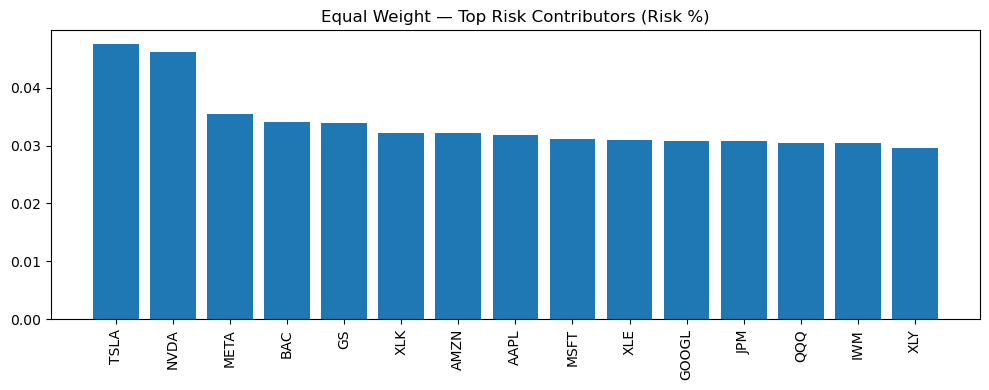

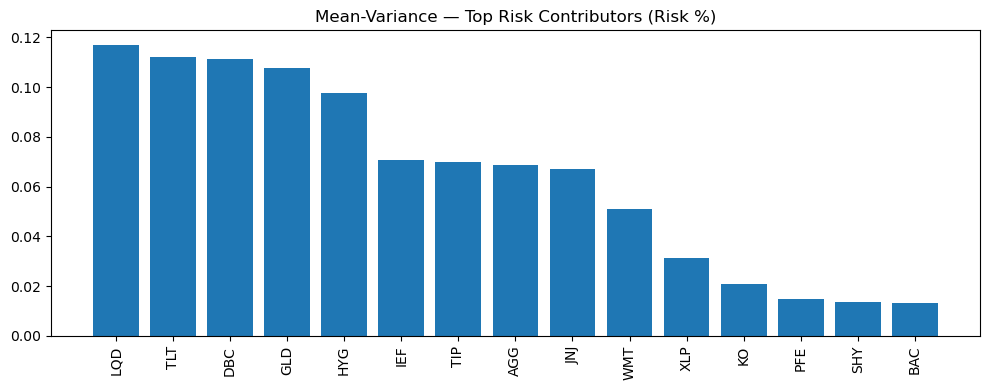

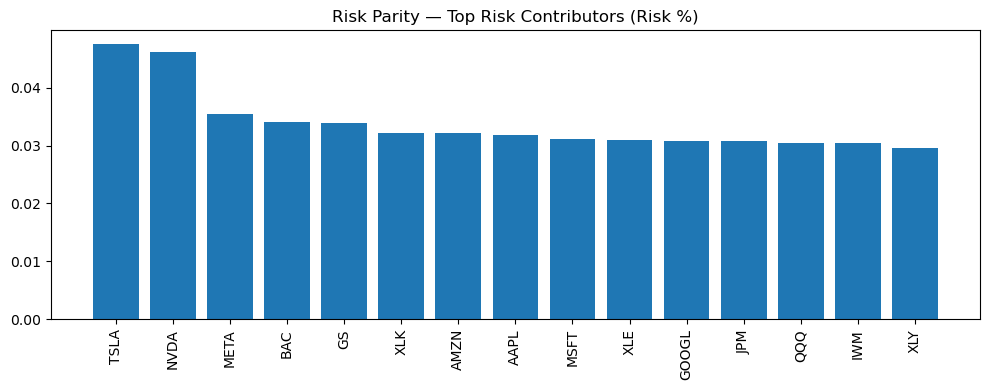

In [7]:
def plot_risk_pct(tab, title):
    s = tab["risk_pct"].sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,4))
    plt.bar(s.index, s.values)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_risk_pct(tab_equal, "Equal Weight — Top Risk Contributors (Risk %)")
plot_risk_pct(tab_mvo,   "Mean-Variance — Top Risk Contributors (Risk %)")
plot_risk_pct(tab_rp,    "Risk Parity — Top Risk Contributors (Risk %)")


In [8]:
WINDOW = 252  # 1Y rolling
tick = assets  # alias

def rolling_cov(returns_window):
    return returns_window.cov().values

dates = rets.index[WINDOW:]
rolling_risk = []

for i, dt in enumerate(dates, start=WINDOW):
    rwin = rets.iloc[i-WINDOW:i]
    cov = rolling_cov(rwin)

    for name, w in [("Equal Weight", w_equal), ("Mean-Variance", w_mvo), ("Risk Parity", w_rp)]:
        c = crc(w, cov)
        rpct = c / c.sum()
        rolling_risk.append(pd.DataFrame({
            "date": dt,
            "portfolio": name,
            "ticker": assets,
            "risk_pct": rpct
        }))

rolling_risk_df = pd.concat(rolling_risk, ignore_index=True)
rolling_risk_df.head()


,date,portfolio,ticker,risk_pct
0,2015-01-05,Equal Weight,AAPL,0.023121
1,2015-01-05,Equal Weight,AGG,-0.001605
2,2015-01-05,Equal Weight,AMZN,0.047051
3,2015-01-05,Equal Weight,BAC,0.032040
4,2015-01-05,Equal Weight,BRK-B,0.024123


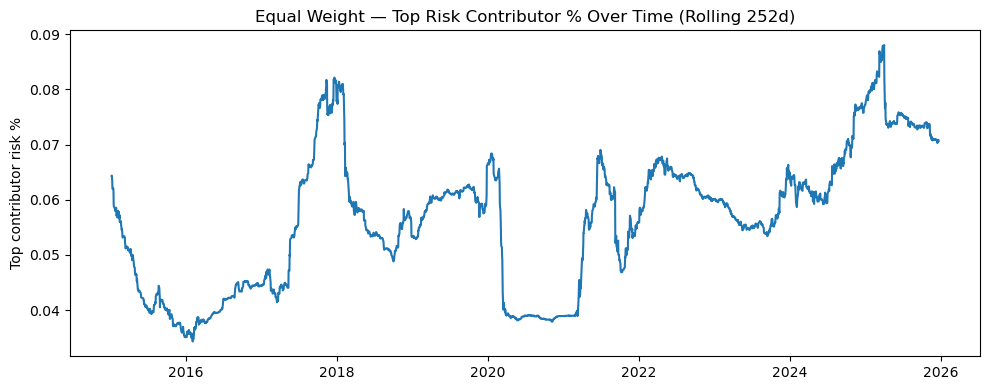

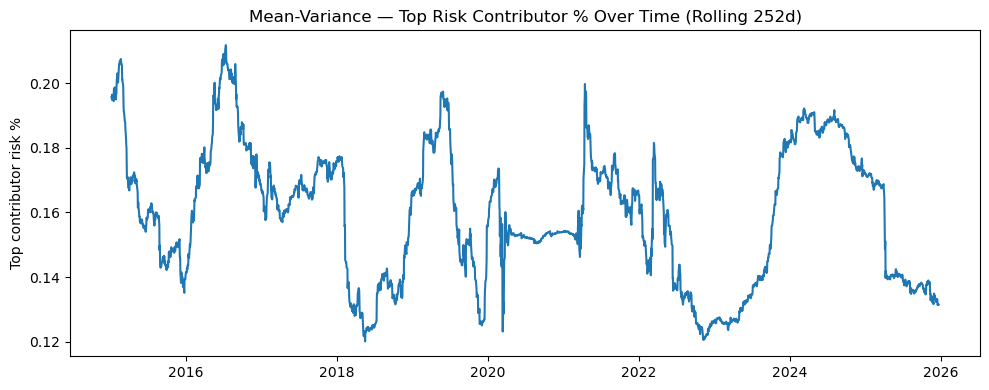

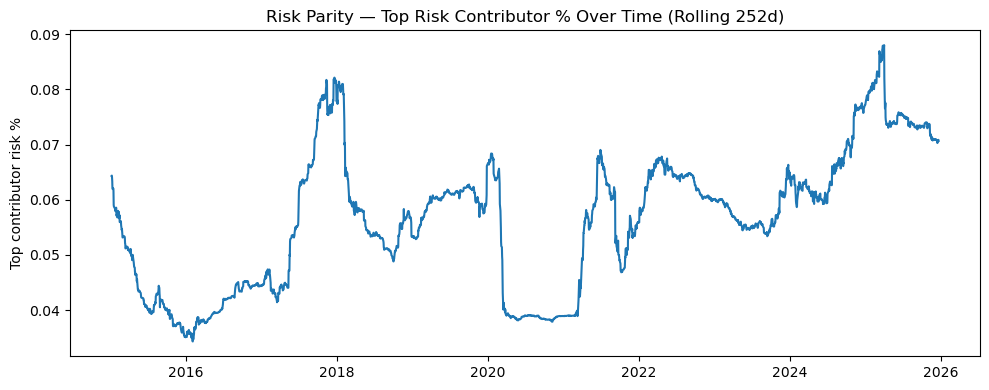

,date,ticker,risk_pct
0,2015-01-05,GLD,0.195722
1,2015-01-06,GLD,0.195292
2,2015-01-07,GLD,0.196432
3,2015-01-08,GLD,0.194744
4,2015-01-09,GLD,0.195287


In [9]:
def plot_top1_over_time(df, portfolio_name):
    sub = df[df["portfolio"] == portfolio_name].copy()
    # for each date, find top contributor
    top = sub.loc[sub.groupby("date")["risk_pct"].idxmax()]
    plt.figure(figsize=(10,4))
    plt.plot(top["date"], top["risk_pct"])
    plt.title(f"{portfolio_name} — Top Risk Contributor % Over Time (Rolling {WINDOW}d)")
    plt.ylabel("Top contributor risk %")
    plt.tight_layout()
    plt.show()
    return top[["date","ticker","risk_pct"]].reset_index(drop=True)

top1_equal = plot_top1_over_time(rolling_risk_df, "Equal Weight")
top1_mvo   = plot_top1_over_time(rolling_risk_df, "Mean-Variance")
top1_rp    = plot_top1_over_time(rolling_risk_df, "Risk Parity")

top1_mvo.head()


In [10]:
static.to_csv("data/processed/risk_attribution_static.csv", index=False)
rolling_risk_df.to_parquet("data/processed/risk_attribution_rolling.parquet")

print("Saved: data/processed/risk_attribution_static.csv")
print("Saved: data/processed/risk_attribution_rolling.parquet")


Saved: data/processed/risk_attribution_static.csv
Saved: data/processed/risk_attribution_rolling.parquet
